In [1]:
import os
import sys
root_dir = os.path.split(os.getcwd())[0]
script_dir = os.path.join(root_dir, 'script')
if script_dir not in sys.path:
    sys.path.append(script_dir)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import metrics

import pickle

from export_predictions import CACHE_FOLDER
from data.util import onehot_to_targets
from model.util import load_predictions_results, ModelParameters

/home/viktor/venvs/dp/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2018-06-10 14:26:29,371 [matplotlib.backe] [DEBUG]  backend module://ipykernel.pylab.backend_inline version unknown


## Load test data and predictions of models

In [3]:
with open(os.path.join(CACHE_FOLDER, 'clips.pickle'), 'rb') as f:
    df = pickle.load(f)
with open(os.path.join(CACHE_FOLDER, 'clipsPilot.pickle'), 'rb') as f:
    dfPilot = pickle.load(f)
with open(os.path.join(CACHE_FOLDER, 'clipsFlow.pickle'), 'rb') as f:
    dfFlow = pickle.load(f)
with open(os.path.join(CACHE_FOLDER, 'imgs.pickle'), 'rb') as f:
    dfImgs = pickle.load(f)


# Correct segment names that should be in one category
_correct_segments = {
'MWSelfReports_Interactive Site': 'MW. Self report (Interactive Site)',
'MWSelfReports_Text - Eng': 'MW. Self report (Text - Eng)',
'MWSelfReports_Video - Eng': 'MW. Self report (Video - Eng)',
'MWSelfReports_Video - Mind Wandering': 'Video - Mind Wandering', # Somebody pressed 'q' during Mind wndering task
'RockNPoll - High Eng': 'Interactive Site'
} 
correct_segment = lambda x: _correct_segments[x] if x in _correct_segments.keys() else x

def preprocess_data(_df):
    _df.segment = _df.segment.apply(correct_segment)
    _df['target_pred'] = _df['targets']
    _df['targets'] = onehot_to_targets(_df['target_pred'])

    
preprocess_data(df)
preprocess_data(dfPilot)
preprocess_data(dfFlow)
preprocess_data(dfImgs)

dfPilot['00_pred'] = list(load_predictions_results('cnn-lstm-small_cvsplit_0'))
df['04_pred'] = list(load_predictions_results('cnn-lstm-small_v04'))
df['05_pred'] = list(load_predictions_results('cnn-lstm-small_v05'))
df['06_pred'] = list(load_predictions_results('cnn-lstm-small_v06'))
dfFlow['06_pred'] = list(load_predictions_results('cnn-lstm-small_flow_v06'))
df['08_pred'] = list(load_predictions_results('cnn-lstm-small_v08'))
dfImgs['01_pred'] = list(load_predictions_results('cnn_v01'))[:-4]

dfPilot['00_target'] = onehot_to_targets(dfPilot['00_pred'])
df['04_target'] = onehot_to_targets(df['04_pred'])
df['05_target'] = onehot_to_targets(df['05_pred'])
df['06_target'] = onehot_to_targets(df['06_pred'])
dfFlow['06_target'] = onehot_to_targets(dfFlow['06_pred'])
df['08_target'] = onehot_to_targets(df['08_pred'])
dfImgs['01_target'] = onehot_to_targets(dfImgs['01_pred'])

## Handy constants

In [4]:
engaged_segments = ['Interactive Site', 'Mind Game', 'Text - Eng', 'Video', 'Video - Eng']
disengaged_segments = ['Disengagement', 'Disengagement Mobile', 'Disengagement Room',
       'MW. Self report (Text - Eng)', 'MW. Self report (Video - Eng)',
       'MW. Self report (Interactive Site)', 'Mind Wandering', 'Text - Diseng',
       'Text - Mind Wandering', 'Video - Diseng', 'Video - Mind Wandering']

## Setup eval functions

In [5]:
# Metric computation
####################

def accuracy_of_groups(df, group_column, targets_column):
    df_groupbyed = df.groupby(group_column)
    return pd.Series({group: metrics.accuracy_score(data['targets'], data[targets_column]) for group, data in df_groupbyed})

def accuracy_per_segment(df, targets_column):
    return accuracy_of_groups(df, 'segment', targets_column)

def accuracy_per_participant(df, targets_column):
    return accuracy_of_groups(df, 'participant', targets_column)

def accuracy(df, targets_column):
    return metrics.accuracy_score(df['targets'], df[targets_column])


# Selecting per records
########################
def _make_record_field(row):
    orig_segment = row.segment
    if row.segment.startswith('MW. Self report ('):
        orig_segment = re.match(r'(:?MW. Self report \()?(.*)\)', row.segment).groups()[-1]
    return '{}/{}'.format(row.participant, orig_segment)


def _make_record_column(df):
    # MW. Self report (Video - Eng)
    return df.apply(_make_record_field, axis=1)


def _make_clip_sort_field(frames):
    # Get sequence and first frame of clip
    sequence, frame = frames[0].rsplit('/', 2)[1:]

    sortable_seq_label = re.match(
        r'(MWSelfReports_)?(.*)', sequence
    ).groups()
    
    # Add '_' in order to sort SelfRep. sequence after original 
    sortable_seq_label = sortable_seq_label[-1] if sortable_seq_label[0] is None else sortable_seq_label[-1] + '_'
    
    return sortable_seq_label + '/' + frame


def _make_clip_sort_column(df):
    return df.frames.apply(_make_clip_sort_field)


def get_clips_per_record(df):
    df = df.copy()
    
    df['record'] = _make_record_column(df)
    
    df['clip_sort'] = _make_clip_sort_column(df)
    
    return {record: data.sort_values('clip_sort') for record, data in df.groupby('record')}


# Printing results
####################

def evaluate_model_acc_text(df, target_column, report_fn):
    print('Accuracy on the entire dataset:', accuracy(df, target_column), '\n')

    print('Accuracy per segment:', '\n')
    acc_seg = accuracy_per_segment(df, target_column)

    print('(Engaged label)')
    print(acc_seg.loc[engaged_segments], '\n')

    print('(Disengaged label)')
    print(acc_seg.loc[disengaged_segments], '\n')

    print('Accuracy per participant:')
    print(accuracy_per_participant(df, target_column), '\n')

    print('Classification distribution:\n')
    print('Engaged: %d of %d' % (df[target_column][df[target_column] == 1].count(), len(df)))
    print('Disengaged: %d of %d' % (df[target_column][df[target_column] == 0].count(), len(df)))
    
def plot_segment_acc(df, target_column, ax=None):
    if ax is None:
        fig_seg = plt.figure(figsize=(10,3))
        ax = fig_seg.add_subplot(111)
    
    title = 'Accuracy per segment'
    xlabel = 'Segment'
    
    acc_seg = accuracy_per_segment(df, target_column)
    plt.setp(ax.get_xticklabels(), rotation=-30, horizontalalignment='left', fontsize=10)
    
    ax.set_ylim([0.0,1.1])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)
    
    data = acc_seg.loc[engaged_segments]
    ax.bar(data.index, data.values, color='blue', label='Engaged')
    data = acc_seg.loc[disengaged_segments]
    ax.bar(data.index, data.values, color='red', label='Disengaged')
    
    ax.legend(loc=9, bbox_to_anchor=(1.1, 0.7))
    

def plot_participant_acc(df, target_column, ax=None):
    if ax is None:
        fig_par = plt.figure(figsize=(10,3))
        ax = fig_par.add_subplot(111)
    
    title = 'Accuracy per participant'
    xlabel = 'Participant'
    
    ax.set_ylim([0.0,1.1])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)

    acc_par = accuracy_per_participant(df, target_column)
    ax.bar(acc_par.index, acc_par.values, color='lightblue')
        
def get_true_positive_percentage(df, target_column):
    count = len(df)
    df_positive = df[df.targets == 1]
    tp = len(df_positive[df_positive[target_column] == 1])
    return tp / count
       
def get_true_negative_percentage(df, target_column):
    count = len(df)
    tn = 1
    df_negative = df[df.targets == 0]
    tn = len(df_negative[df_negative[target_column] == 0])
    return tn / count
        
def get_sensitivity(df, target_column):
    df_engaged = df[df.targets == 1]  # tp + fn
    count = len(df_engaged)
    tp = len(df_engaged[df_engaged[target_column] == 1])
#     fn = len(df_positive[df_positive[target_column] == 0])
    return tp / count if count > 0 else 0
       
def get_specificity(df, target_column):
    df_disengaged = df[df.targets == 0] # fp + tn
    count = len(df_disengaged)
    tn = len(df_disengaged[df_disengaged[target_column] == 0])
    return tn / count if count > 0 else 0
    
def plot_participant_accuracy_distr(df, target_column, ax=None):
    if ax is None:
        fig_par = plt.figure(figsize=(10,3))
        ax = fig_par.add_subplot(111)
        
    title = 'Accuracy per participant'
    xlabel = 'Participant'

    participants = []
    tps = []
    tns = []
    
    for par, data in df.groupby('participant'):
        participants.append(par)
        tps.append(get_true_positive_percentage(data, target_column))
        tns.append(get_true_negative_percentage(data, target_column))

    ax.set_ylim([0.0,1.1])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)

    ax.bar(participants, tps, color='blue', label='Engaged')
    ax.bar(participants, tns, bottom=tps, color='red', label='Disengaged')

    ax.legend(loc=9, bbox_to_anchor=(1.1, 0.7))
    
def plot_seg_par_cross_validation(df, target_column):
    fig = plt.figure(figsize=(12,18))
    
    participants = df.participant.unique()
    segments = df.segment.unique()
    
    gs = gridspec.GridSpec(len(segments), len(participants)) 
    fig.subplots_adjust(hspace=1.0)
    
    i = 0
    bars = ['0', '1']
    
    for segment in segments:
        df_segment = df[df.segment == segment]
        for participant in participants:
            _df = df_segment[df.participant == participant]
            tp = get_sensitivity(_df, target_column)
            tn = get_specificity(_df, target_column)
            
            ax = fig.add_subplot(gs[i])
            ax.set_ylim([0.0,1.1])
            
            ax.bar(bars, [tp, 0], color='blue', label='Engaged')
            ax.bar(bars, [0, tn], bottom=[tp, 0], color='red', label='Disengaged')
            
            i += 1
            
    plt.show()
    

def evaluate_model_acc(df, target_column):
    print('Accuracy on the entire dataset:', accuracy(df, target_column), '\n')
    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 4]) 
    fig.subplots_adjust(hspace=1.0)
    
    ax1 = fig.add_subplot(gs[0])
    plot_segment_acc(df, target_column, ax1)
    
    ax2 = fig.add_subplot(gs[1])
    plot_participant_accuracy_distr(df, target_column, ax2)
    
    print('Classification distribution:\n')
    print('Engaged: %d of %d' % (df[target_column][df[target_column] == 1].count(), len(df)))
    print('Disengaged: %d of %d' % (df[target_column][df[target_column] == 0].count(), len(df)))
    
    plt.show()

# Evaluate cnn-lstm-small_cvsplit_0

Accuracy on the entire dataset: 0.7339821573398215 



2018-05-01 11:51:08,566 [matplotlib.font_] [DEBUG]  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/viktor/venvs/dp/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-05-01 11:51:08,669 [matplotlib.font_] [DEBUG]  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to DejaVu Sans ('/home/viktor/venvs/dp/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-05-01 11:51:08,698 [matplotlib.font_] [DEBUG]  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('/home/viktor/venvs/dp/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


Classification distribution:

Engaged: 1258 of 3699
Disengaged: 2441 of 3699


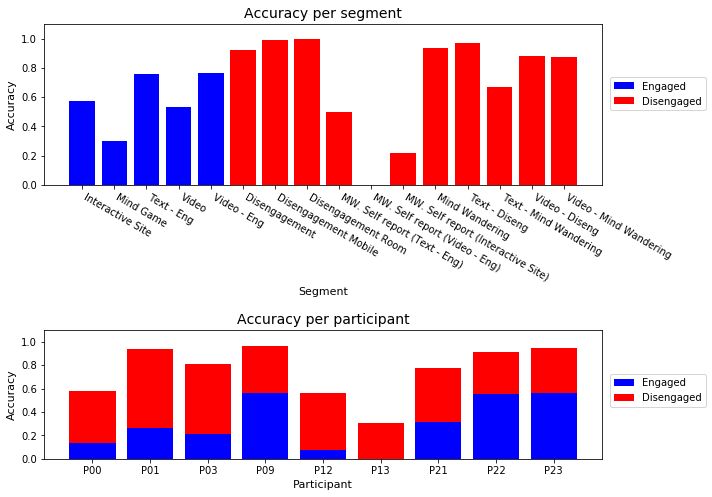

In [28]:
evaluate_model_acc(dfPilot, '00_target')

In [46]:
# Mind Game acc
accuracy_per_participant(dfPilot.loc[dfPilot.segment == 'Mind Game'], '00_target')

P09    0.911392
P13    0.000000
dtype: float64

# Evaluate cnn-lstm-small_v04

Accuracy on the entire dataset: 0.49766233766233764 

Classification distribution:

Engaged: 0 of 3850
Disengaged: 3850 of 3850


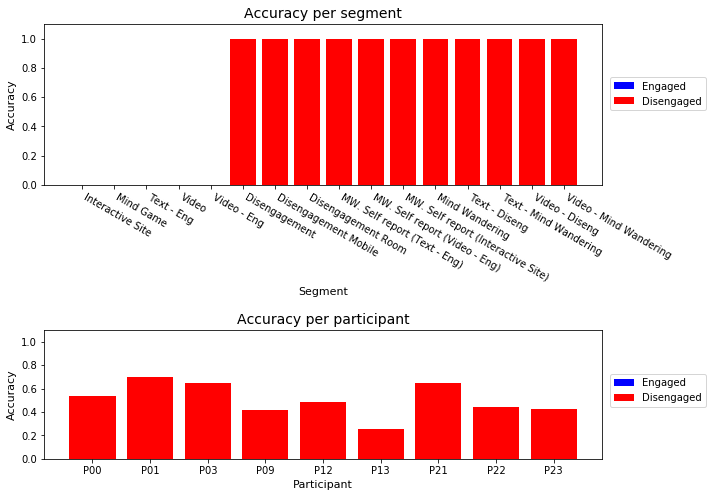

In [165]:
evaluate_model_acc(df, '04_target')

# Evaluate cnn-lstm-small_v05

Accuracy on the entire dataset: 0.5797402597402598 

Classification distribution:

Engaged: 2300 of 3850
Disengaged: 1550 of 3850


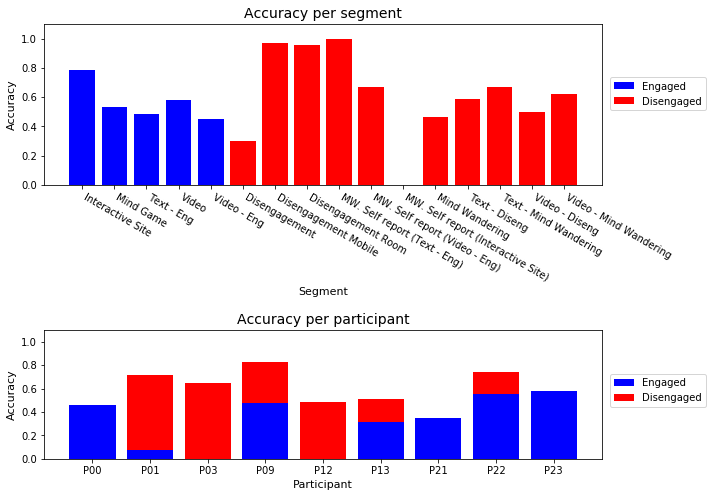

In [166]:
evaluate_model_acc(df, '05_target')

In [174]:
tp = get_true_positive_percentage(df.loc[df.participant=='P13'], '05_target')
tn = get_true_negative_percentage(df.loc[df.participant=='P13'], '05_target')
tp / (tp+tn)

0.6138211382113821

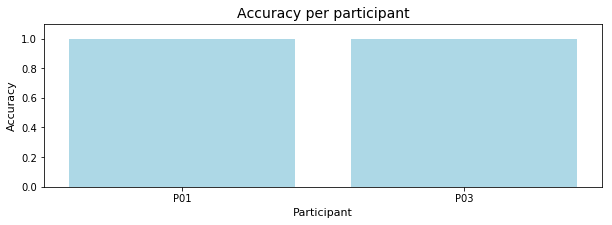

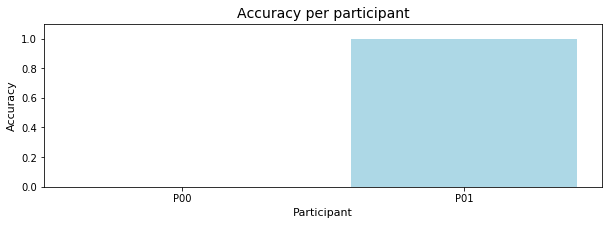

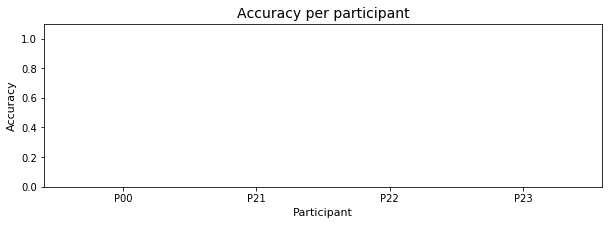

In [176]:
plot_participant_acc(df.loc[df.segment=='MW. Self report (Text - Eng)'], '05_target')
plot_participant_acc(df.loc[df.segment=='MW. Self report (Video - Eng)'], '05_target')
plot_participant_acc(df.loc[df.segment=='MW. Self report (Interactive Site)'], '05_target')

# Evaluate cnn-lstm-small_v06

Accuracy on the entire dataset: 0.7067532467532468 

Classification distribution:

Engaged: 1449 of 3850
Disengaged: 2401 of 3850


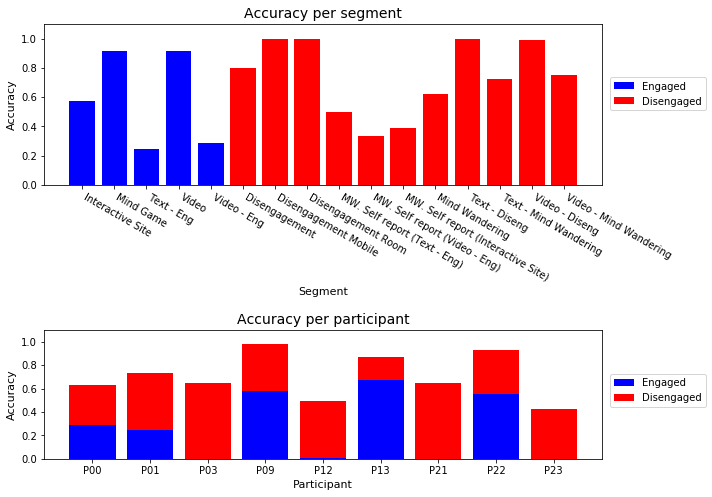

In [167]:
evaluate_model_acc(df, '06_target')

### Analysis of evaluation
- _Text - Eng_, _Video - Eng_ were not classified correctly
    - Possibly due to Mind Wandering self reports, because they are hard to distinguish since they are extracted from the same segment
    - Mabye it is Test related - NO (see diseng for Test 1)
- why is Video in Test 2 classified correctly and Test 1 not ?
    - Participant bias ?
- why is participant P22 classified more accurately than others in Test 3 ?
- regarding _Test 1_ there is very little deviation between partic. acc. (warrning _P00_)

# Evaluate cnn-lstm-small_flow_v06

Accuracy on the entire dataset: 0.5301298701298701 

Classification distribution:

Engaged: 3374 of 3850
Disengaged: 476 of 3850


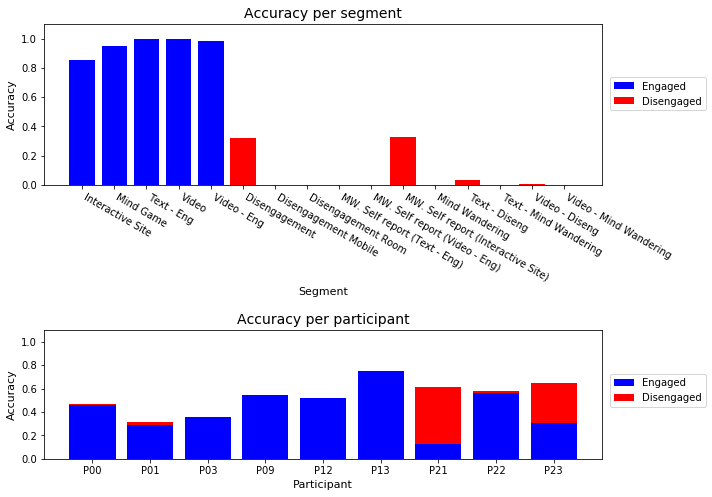

In [168]:
evaluate_model_acc(dfFlow, '06_target')

# Evaluate cnn-lstm-small_v08

Accuracy on the entire dataset: 0.6722077922077923 

Classification distribution:

Engaged: 1926 of 3850
Disengaged: 1924 of 3850


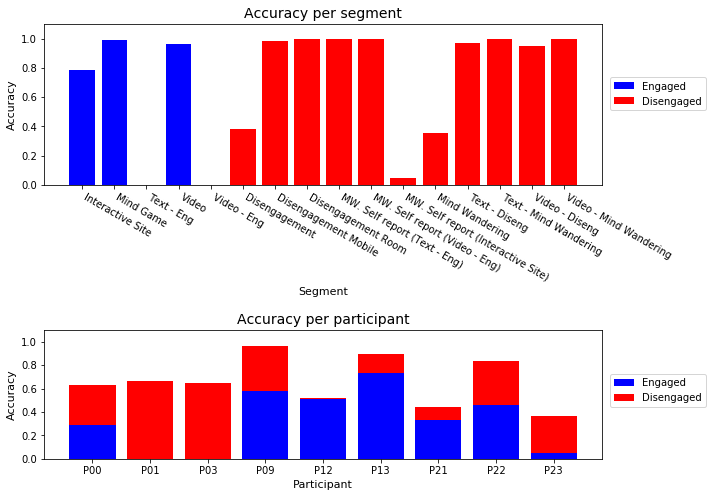

In [169]:
evaluate_model_acc(df, '08_target')

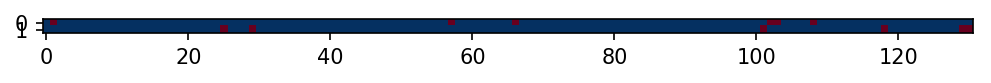

In [291]:
# records = get_clips_per_record(df)
# record = records['P00/Interactive Site']
# record.segment.unique()
# df[df.participant=='P00'].segment.unique()

# target_column = '06_target'
# fr = record.iloc[0]

def _get_clip_color(row):
    color = 1.0 if row.targets == row[target_column] else 0.3
    if row.segment.startswith('MW. Self report ('):
        color *= -1
    return color

def get_record_acc_image(record):
    return np.atleast_2d(record.apply(_get_clip_color, axis=1).as_matrix())

fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(111)
colormap = 'RdBu'
ax.imshow(get_record_acc_image(record).reshape(2, -1), colormap)
plt.show()



Accuracy on the entire dataset: 0.5891474071985895 

Classification distribution:

Engaged: 343951 of 837164
Disengaged: 493213 of 837164


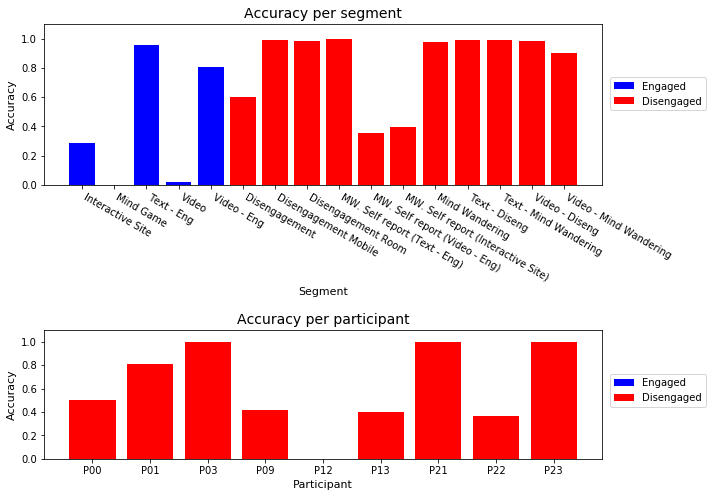

In [59]:
evaluate_model_acc(dfImgs, '01_target')

In [58]:
# plot_participant_acc(dfImgs.loc[dfImgs.segment=='Interactive Site'], '01_target')
# plot_participant_acc(dfImgs.loc[dfImgs.segment=='Disengagement'], '01_target')
# x = dfImgs[dfImgs.targets == dfImgs['01_target']]
# len(x)
# x_eng = x[x['01_target'] == 1]
dfImgs[dfImgs['01_target']]

0

In [37]:
eng_to_svk_segment = {
    'MW. Self report (Interactive Site)': 'Nahlásené MO (Interaktívna Stránka)',
    'MW. Self report (Text - Eng)': 'Nahlásené MO (Text - Zaujatie)',
    'MW. Self report (Video - Eng)': 'Nahlásené MO (Video - Zaujatie)',
    'Interactive Site': 'Interaktívna stránka',
    'Text - Eng': 'Text - Zaujatie',
    'Video - Eng': 'Video - Zaujatie',
    'Mind Game': 'Pexeso',
    'Video': 'Video',
    'Text - Mind Wandering': 'Text - Myšienkové odbehnutie',
    'Video - Mind Wandering': 'Video - Myšlienkové odbehnutie', # Somebody pressed 'q' during Mind wndering task
    'Mind Wandering': 'Myšienkové odbehnutie',
    'Disengagement': 'Nezaujatie',
    'Disengagement Room': 'Nezaujatie Miestnosť',
    'Disengagement Mobile': 'Nezaujatie Mobil',
    'Text - Diseng': 'Text - Nezaujatie ',
    'Video - Diseng': 'Video - Nezaujatie',
}
df_svk = df.copy()
df_svk['segment'] = df_svk['segment'].apply(lambda x: eng_to_svk_segment[x])
dfFlow_svk = dfFlow.copy()
dfFlow_svk['segment'] = dfFlow_svk['segment'].apply(lambda x: eng_to_svk_segment[x])
dfPilot_svk = dfPilot.copy()
dfPilot_svk['segment'] = dfPilot_svk['segment'].apply(lambda x: eng_to_svk_segment[x])

In [42]:
def get_engaged_data(_df=None):
    if _df is None:
        _df = df
    return _df[_df['targets'] == 1]

def get_disengaged_data(_df=None):
    if _df is None:
        _df = df
    return _df[_df['targets'] == 0]

def plot_segment_metric(_df, metric_fn, title, ylabel, ax=None):
    if ax is None:
        fig_seg = plt.figure(figsize=(10,3))
        ax = fig_seg.add_subplot(111)
    
    xlabel = 'Segment'
    
    plt.setp(ax.get_xticklabels(), rotation=-30, horizontalalignment='left', fontsize=12)
    
#     ax.set_ylim([0.0,1.1])
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    data = metric_fn(get_engaged_data(_df))
    data = data.sort_values(ascending=False)
    ax.bar(data.index, data.values, color='blue', label='Zaujatý')
    data = metric_fn(get_disengaged_data(_df))
    data = data.sort_values(ascending=False)
    ax.bar(data.index, data.values, color='red', label='Nezaujatý')
    
    ax.legend(loc=9, bbox_to_anchor=(1.15, 0.7), prop={'size': 16})
    
def plot_segment_accuracy(_df, target, ax=None, title='Accuracy pre segmenty'):
    plot_segment_metric(
        _df=_df,
        metric_fn=lambda x: accuracy_per_segment(x, target), 
        title=title, 
        ylabel='Accuracy',
        ax=ax)

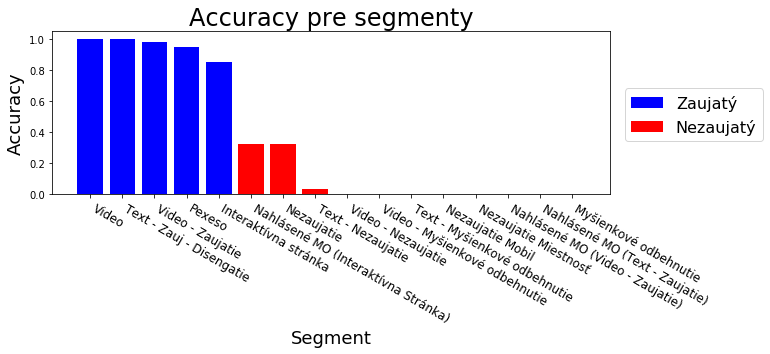

In [31]:
plot_segment_accuracy(dfFlow_svk, '06_target')

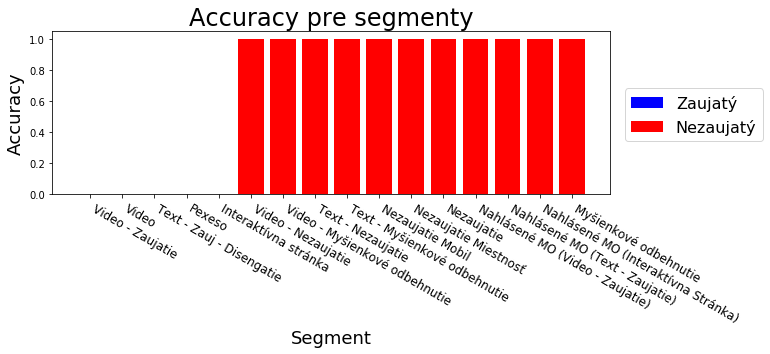

In [35]:
plot_segment_accuracy(df_svk, '04_target')

In [43]:
def plot_participant_acc_per_segment(_df, participant, target):
    plot_segment_accuracy(_df.loc[_df.participant==participant], target, title='Accuracy {} participanta'.format(participant))

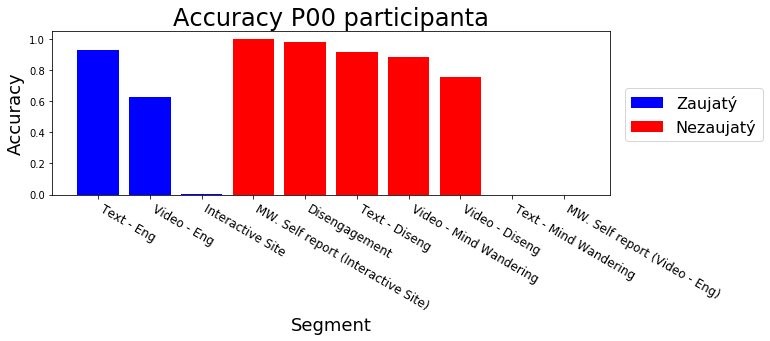

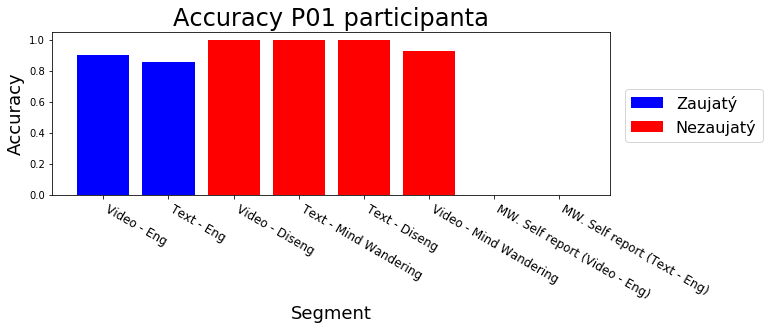

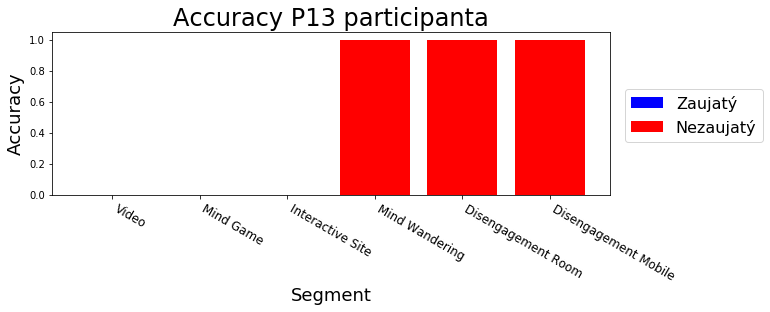

In [44]:
plot_participant_acc_per_segment(dfPilot, 'P00', '00_target')
plot_participant_acc_per_segment(dfPilot, 'P01', '00_target')
plot_participant_acc_per_segment(dfPilot, 'P13', '00_target')